In [11]:
from dsets import lvis_dataset,transformations
from torchvision import transforms


annotations="datasets/lvis/data"
root=""
inp_dim=416

lv = lvis_dataset.LVISDetection(root = '../../../datasets/coco/images',
                    annFile = '../../../datasets/lvis/data/lvis_val_100.json',
                    subset=1,
                    transform=transforms.Compose([
                        transformations.ResizeToTensor(inp_dim)
                                           ]))

In [4]:
import torch
state_dict = torch.load('output/coco_baseline/checkpoints/last.tar')['model_state_dict']
# create new OrderedDict that does not contain `module.`
from collections import OrderedDict
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    name = k[7:] # remove `module.`
    new_state_dict[name] = v
# load params
torch.save(new_state_dict, "output/coco_baseline/checkpoints/last1.tar")

## Train

In [14]:
from torch.utils.data import DataLoader
from utilities import helper
from torch import optim
import torch
from nets.yolohead import YoloHead
from nets.yolo_loss import YOLOLoss
import sys
from dsets import coco_dataset,transformations
from torchvision import transforms
from utilities import helper
import torch
from apex import amp
from torch import nn
import numpy as np
from torchvision.ops import boxes
from utilities.telemetry import Telemetry 

annotations="../../../datasets/coco/annotations/instances_train2017.json"
root='../../../datasets/coco/images'
inp_dim=416

cc = coco_dataset.CocoDetection(root = root,
                    annFile = annotations,
                    subset=1,
                    transform=transforms.Compose([
                        transformations.ResizeToTensor(inp_dim),
                        transformations.COCO91_80()
                                           ]))

test_dataloader=DataLoader(cc,batch_size=6,shuffle=True, num_workers=0,collate_fn=helper.collate_fn)
test_dataloader.dset_name='coco'

config = {"backbone": {"backbone_name": "darknet_53",
                           "backbone_pretrained": "./weights/darknet53_weights_pytorch.pth"},
        "yolo": {"anchors": [[[116, 90], [156, 198], [373, 326]],
                    [[30, 61], [62, 45], [59, 119]],
                    [[10, 13], [16, 30], [33, 23]]],
                "classes": 80,
                "img_size":[416,416],
                "ignore_threshold" : 0.5,
                "lambda_xy" : 2.5,
                "lambda_wh" : 2.5,
                "lambda_conf" : 1.0,
                "lambda_no_conf": 0.5,
                "lambda_cls" : 1.0}
        }

model = YoloHead(config)
model.load_state_dict(torch.load('weights/yolov3_orig.pth'))
model=model.cuda()
optimizer=optim.SGD(model.parameters(), lr=0.001)
wh_loss = nn.MSELoss()
xy_loss = nn.BCEWithLogitsLoss()
conf_loss = nn.BCEWithLogitsLoss()
class_loss = nn.BCEWithLogitsLoss()

yolo_loss=[]
for i in range(3):
    yolo_loss.append(YOLOLoss(config['yolo'],i))

anchors=config['yolo']['anchors']
for batch_idx,(imgs,targets) in enumerate(test_dataloader):
    optimizer.zero_grad()
    print(targets)
    batch_loss=0
    
    out=model(imgs.cuda())
    tel = Telemetry(out,imgs,targets)
    break
    for k,y in enumerate(out):
        input=y
        bs = input.size(0)
        in_h = input.size(2)
        in_w = input.size(3)
        stride_h = inp_dim / in_h
        stride_w = inp_dim / in_w
        scaled_anchors = [(a_w / stride_w, a_h / stride_h) for a_w, a_h in anchors[k]]

        prediction = input.view(bs,3,85, in_h, in_w).permute(0, 1, 3, 4, 2).contiguous()

        # Get outputs
        x = prediction[..., 0]                       # Center x
        y = prediction[..., 1]                        # Center y
        w = prediction[..., 2]                         # Width
        h = prediction[..., 3]                         # Height
        conf = prediction[..., 4]                     # Conf
        pred_cls = prediction[..., 5:]                # Cls pred.

        if targets is not None:
            #  build target
            mask, noobj_mask, tx, ty, tw, th, tconf, tcls = get_target(targets, scaled_anchors,in_w,in_h,ignore_threshold=0.5)

            tx, ty, tw, th = tx.cuda(), ty.cuda(), tw.cuda(), th.cuda()
            tconf, tcls = tconf.cuda(), tcls.cuda()
            break
            #  losses.
            loss_x = xy_loss(x[mask], tx[mask])
            loss_y = xy_loss(y[mask], ty[mask])
            loss_w = wh_loss(w[mask], tw[mask])
            loss_h = wh_loss(h[mask], th[mask])
            loss_conf = 1 * conf_loss(conf[mask], tconf[mask]) + \
                0.5 * conf_loss(conf[noobj_mask], torch.zeros(conf[noobj_mask].shape,device=torch.device('cuda')))
            loss_cls = class_loss(pred_cls[mask], tcls[mask])
            #  total loss = losses * weight
            loss = loss_x * 2.5 + loss_y * 2.5 + \
                loss_w * 2.5 + loss_h * 2.5 + \
                loss_conf + loss_cls * 1
            outcome = [loss, loss_x.detach(), loss_y.detach(), loss_w.detach(),\
            loss_h.detach(), loss_conf.detach(), loss_cls.detach()]
            print(outcome)

        batch_loss=batch_loss+outcome[0]

    batch_loss.backward()

    if (batch_idx + 1) % 1 == 0:
        sys.stdout.write(f'\r{batch_loss.detach()}')
        sys.stdout.flush()

    optimizer.step()
        


loading annotations into memory...
Done (t=18.08s)
creating index...
index created!
[{'bbox': tensor([[0.7241, 0.9111, 0.2142, 0.1731],
        [0.5260, 0.6101, 0.6581, 0.3573],
        [0.5300, 0.6090, 0.6565, 0.3550],
        [0.1636, 0.5422, 0.1240, 0.0470],
        [0.4080, 0.7807, 0.0245, 0.0590],
        [0.3683, 0.8562, 0.0929, 0.0899],
        [0.7218, 0.9076, 0.2207, 0.1848]]), 'img_size': tensor([456, 640,   3]), 'category_id': tensor([2, 4, 4, 4, 0, 7, 7]), 'area': tensor([0.0227, 0.0699, 0.0696, 0.0018, 0.0006, 0.0054, 0.0291]), 'image_id': tensor(508881)}, {'bbox': tensor([[0.6517, 0.7393, 0.2247, 0.3461],
        [0.7275, 0.7733, 0.0568, 0.0473]]), 'img_size': tensor([640, 480,   3]), 'category_id': tensor([ 0, 35]), 'area': tensor([0.0402, 0.0017]), 'image_id': tensor(45920)}, {'bbox': tensor([[0.2179, 0.4955, 0.4297, 0.5878]]), 'img_size': tensor([424, 640,   3]), 'category_id': tensor([7]), 'area': tensor([0.2010]), 'image_id': tensor(80303)}, {'bbox': tensor([[0.3027,

In [2]:
print(targets)

[{'bbox': tensor([[0.3490, 0.5663, 0.2750, 0.7910],
        [0.5525, 0.4953, 0.0540, 0.2051],
        [0.8960, 0.5071, 0.0689, 0.2128],
        [0.8555, 0.4867, 0.0401, 0.1794],
        [0.2008, 0.4943, 0.0488, 0.1810],
        [0.1125, 0.4997, 0.0702, 0.2309],
        [0.1513, 0.5007, 0.0623, 0.1866],
        [0.5974, 0.5015, 0.0925, 0.2112],
        [0.5735, 0.4237, 0.0180, 0.0333],
        [0.6291, 0.4067, 0.0759, 0.0980]]), 'img_size': tensor([502, 640,   3]), 'category_id': tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  0, 32]), 'area': tensor([0.0983, 0.0057, 0.0079, 0.0030, 0.0042, 0.0082, 0.0027, 0.0084, 0.0003,
        0.0055]), 'image_id': tensor(542260)}, {'bbox': tensor([[0.5404, 0.4215, 0.9193, 0.8430],
        [0.8039, 0.6921, 0.3921, 0.3021],
        [0.3415, 0.4711, 0.3251, 0.1857],
        [0.2787, 0.5695, 0.5535, 0.5174]]), 'img_size': tensor([480, 360,   3]), 'category_id': tensor([ 0, 41, 46,  0]), 'area': tensor([0.4808, 0.0793, 0.0263, 0.0909]), 'image_id': tensor(57491

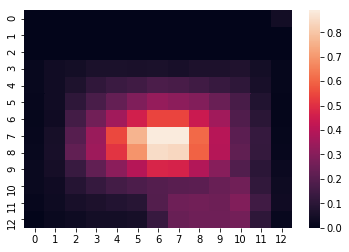

In [110]:
tel.vis_iou(0,0,1)

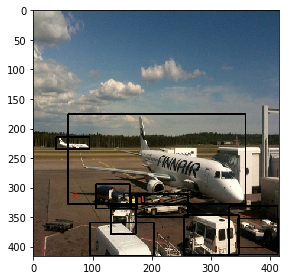

In [103]:

tel.draw_b,1),linelen=2)

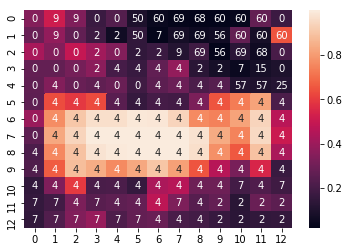

In [104]:
tel.vis_class(,0,2)

In [5]:
targets = [{k: v.to('cuda') for k, v in t.items()} for t in targets]

In [9]:
from torch.utils.data import DataLoader
from utilities import helper
from torch import optim
import torch
from nets.yolohead import YoloHead
from nets.yolo_loss import YOLOLoss
import sys
from dsets import coco_dataset,transformations
from torchvision import transforms
from utilities import helper
import torch
from apex import amp
from torch import nn
import numpy as np
from torchvision.ops import boxes
from utilities.telemetry import Telemetry 

annotations="../../../datasets/coco/annotations/instances_train2017.json"
root='../../../datasets/coco/images'
inp_dim=416

cc = coco_dataset.CocoDetection(root = root,
                    annFile = annotations,
                    subset=1,
                    transform=transforms.Compose([
                        transformations.ResizeToTensor(inp_dim),
                        transformations.COCO91_80()
                                           ]))

test_dataloader=DataLoader(cc,batch_size=6,shuffle=False, num_workers=0,collate_fn=helper.collate_fn)
test_dataloader.dset_name='coco'

config = {"backbone": {"backbone_name": "darknet_53",
                           "backbone_pretrained": "./weights/darknet53_weights_pytorch.pth"},
        "yolo": {"anchors": [[[116, 90], [156, 198], [373, 326]],
                    [[30, 61], [62, 45], [59, 119]],
                    [[10, 13], [16, 30], [33, 23]]],
                "classes": 80,
                "img_size":416,
                "ignore_threshold" : 0.5,
                "lambda_xy" : 2.5,
                "lambda_wh" : 2.5,
                "lambda_conf" : 1.0,
                "lambda_no_conf": 0.5,
                "lambda_cls" : 1.0}
        }

model = YoloHead(config)
# model.load_state_dict(torch.load('weights/yolov3_orig.pth'))
model=model.cuda()
optimizer=optim.SGD(model.parameters(), lr=0.001)
wh_loss = nn.MSELoss()
xy_loss = nn.BCEWithLogitsLoss()
conf_loss = nn.BCEWithLogitsLoss()
class_loss = nn.BCEWithLogitsLoss()

anchors=config['yolo']['anchors']
for batch_idx,(imgs,targets) in enumerate(test_dataloader):
    optimizer.zero_grad()
    targets = [{k: v.to('cuda') for k, v in t.items()} for t in targets]
    batch_loss=0
    
    out=model(imgs.cuda())
    tel=Telemetry(out,imgs,targets)
    losses=forward(out,416,anchors,targets=targets)

    losses[0].backward()
    if (batch_idx + 1) % 1 == 0:
        sys.stdout.write(f'\r{losses[0].detach()},{losses[1].detach()},{losses[2].detach()},{losses[3].detach()},{losses[4].detach()},{losses[5].detach()},{losses[6].detach()}')
        sys.stdout.flush()
    

    optimizer.step()
        

loading annotations into memory...
Done (t=12.40s)
creating index...
index created!
3.0363826751708984,0.7226467728614807,0.3347809910774231,0.637649655342102,0.280286967754364,0.3520762324333191,0.7089419364929199

KeyboardInterrupt: 

In [12]:
iou=bbox_iou(gt, true_pred,(0,0,0),CUDA=True,xcycwh=True)
print(iou)

tensor([0.8405, 0.8202, 0.8530, 0.9481, 0.9097, 0.5201, 0.8207, 0.7263, 0.8217,
        0.6662, 0.6957, 0.9582, 0.9177, 0.9324, 0.8391, 0.9053],
       device='cuda:0', grad_fn=<DivBackward0>)


In [6]:
gt=losses[-1]
pred=losses[-3]
true_pred=losses[-2]
print(true_pred[8:10,4])
print(true_pred[8:10,:4])
print(targets[1]['bbox']*416)

tensor([0.8174, 0.0042], device='cuda:0', grad_fn=<SelectBackward>)
tensor([[324.0353, 187.4025, 153.1376, 261.6665],
        [ 84.4668, 375.5401,  64.5883,  47.7078]], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([[320.4598, 203.7130, 139.7305, 290.1844],
        [ 77.3662, 375.0689,  85.8195,  53.8945]], device='cuda:0')


In [8]:
print(torch.sigmoid(pred[9:10,5:]).max(axis=1)[0])
print(torch.sigmoid(pred[9:10,4]))

tensor([0.9768], device='cuda:0', grad_fn=<MaxBackward0>)
tensor([0.0042], device='cuda:0', grad_fn=<SigmoidBackward>)


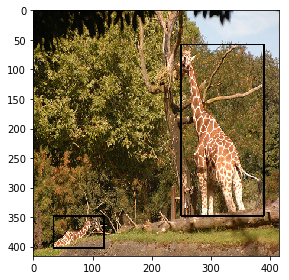

In [10]:
tel.show_gt(1,linelen=2)


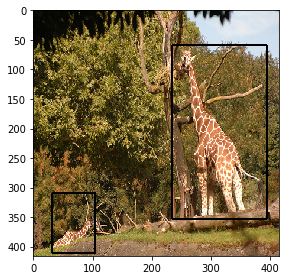

In [11]:
tel.draw_bbs(1,linelen=2)

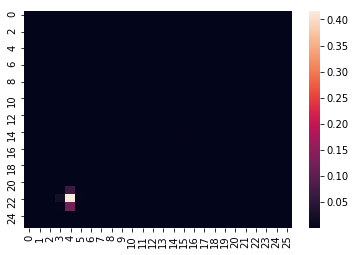

In [29]:
tel.vis_attrib(1,1,2)

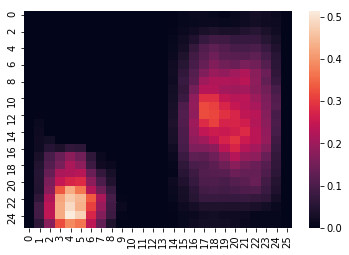

In [30]:
tel.vis_iou(1,1,2)

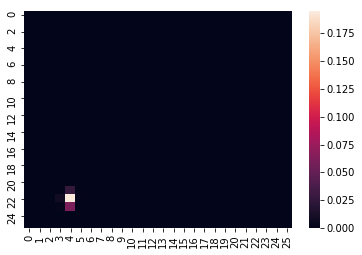

In [31]:
tel.vis_performance(1,1,2)

In [1]:
from torch import nn
def forward(input,img_size,anchors, targets=None):
    device=torch.device('cuda')
    wh_loss = nn.MSELoss()
    xy_loss = nn.BCEWithLogitsLoss()
    conf_loss = nn.BCEWithLogitsLoss()
    class_loss = nn.BCEWithLogitsLoss()
    raw_pred=[]
    cxypwh =[]
    inw_inh=[]
    strides=[]
    for k,input in enumerate(input):
        bs = input.size(0)
        in_h = input.size(2)
        in_w = input.size(3)
        stride_h = img_size / in_h
        stride_w = img_size / in_w
        scaled_anchors = torch.tensor([(a_w / stride_w, a_h / stride_h) for a_w, a_h in anchors[k]])

        prediction = input.view(bs,3,85, in_h, in_w).permute(0, 1, 3, 4, 2).contiguous().contiguous()
        prediction = prediction.permute(0,2,3,1, 4).contiguous()
        prediction = torch.reshape(prediction,[bs,-1,85]).contiguous()
        grid_x = torch.linspace(0, in_w-1, in_w,device=device).repeat(in_w, 1).repeat(3, 1, 1).permute(1,2,0) + 0.5
        grid_y = torch.linspace(0, in_h-1, in_h,device=device).repeat(in_h, 1).t().repeat(3, 1, 1).permute(1,2,0) + 0.5
        grid_x=torch.reshape(grid_x,[-1])/in_w
        grid_y=torch.reshape(grid_y,[-1])/in_h
        anchor_w = torch.tensor(scaled_anchors[:,0],device=device)/in_w
        anchor_w = anchor_w.repeat(1, in_h * in_w)
        anchor_w=torch.reshape(anchor_w,[-1])
        anchor_h = torch.tensor(scaled_anchors[:,1],device=device)/in_h
        anchor_h = anchor_h.repeat(1, in_h * in_w)
        anchor_h=torch.reshape(anchor_h,[-1])
        cxypwh.append(torch.stack((grid_x,grid_y,anchor_w,anchor_h),axis=1))
        raw_pred.append(prediction)
        inw_inh.append(torch.ones(grid_y.shape,device=device)*in_w)
    inw_inh=torch.cat(inw_inh,axis=0)
    raw_pred=torch.cat(raw_pred,axis=1)
    cxypwh=torch.cat(cxypwh,axis=0)
    if targets is not None:
        tgt,tcls,obj_mask, noobj_mask = get_target(targets, cxypwh, inw_inh, ignore_threshold=0.5)
        final=torch.cat([raw_pred[k,i] for k,i in enumerate(obj_mask)])
        true_pred,gt = transform_pred(final,tgt,cxypwh,inw_inh,obj_mask,img_size)

        iou=bbox_iou(gt, true_pred,1,CUDA=True,xcycwh=True)
        iou_loss = 1*(1-iou).mean()
        loss_xy = 1 * xy_loss(final[:,:2],tgt[:,:2])
        loss_wh = 1 * wh_loss(final[:,2:4],tgt[:,2:4])
        pos_conf_loss = conf_loss(final[:,4],torch.ones(final.shape[0],device=device))
        neg_conf_loss = 0.5 * conf_loss(raw_pred[noobj_mask],torch.zeros(raw_pred[noobj_mask].shape,device=device))
        class_loss = class_loss(final[:,5:],tcls)

        loss = iou_loss+ loss_xy +  loss_wh + pos_conf_loss + neg_conf_loss + class_loss

        
        
        return loss,loss_xy,loss_wh,iou_loss,pos_conf_loss,neg_conf_loss,class_loss,final
    else:
        strides = (img_size / inw_inh).unsqueeze(1)
        inw_inh = inw_inh.unsqueeze(1)
        xy=(torch.sigmoid(raw_pred[...,0:2]) + cxypwh[:,:2] * inw_inh - 0.5)*strides
        wh=torch.exp(raw_pred[...,2:4]) * cxypwh[:,2:4] * inw_inh * strides
        conf=torch.sigmoid(raw_pred[:,:,4:5])
        cls=torch.sigmoid(raw_pred[:,:,5:])
        output = torch.cat((xy,wh,conf,cls),axis=2)
        
        return output.data

In [2]:
from utilities import helper
from torchvision.ops import boxes
def get_target(targets, cxypwh, inw_inh, ignore_threshold=0.5):
    obj_mask=[]
    noobj_mask=[]
    tgt=[]
    tcls=[]
    for b,target in enumerate(targets):
        bbox=target['bbox']
        tcls.append(torch.nn.functional.one_hot(target['category_id'],80).float())
        abs_box=helper.get_abs_coord(bbox)
        iou=boxes.box_iou(abs_box,helper.get_abs_coord(cxypwh))
        iou_mask=iou.max(axis=1)[1]
        iou_values=iou.max(axis=1)[0]
        gt=cxypwh[iou_mask].cuda()
        in_wh=inw_inh[iou_mask]
        gx=(bbox[:,0] * in_wh)-(bbox[:,0] * in_wh).long()
        gy=(bbox[:,1] * in_wh)-(bbox[:,1] * in_wh).long()
        gw=torch.log(bbox[:,2]/gt[:,2] + 1e-16)
        gh=torch.log(bbox[:,3]/gt[:,3] + 1e-16)

        tgt.append(torch.stack([gx,gy,gw,gh],axis=1))
        ignore_mask=((iou>ignore_threshold).sum(axis=0))>0
        noobj_mask.append(ignore_mask)
        obj_mask.append(iou_mask)

    noobj_mask=torch.stack(noobj_mask,axis=0)
    tgt=torch.cat(tgt,axis=0)
    tcls=torch.cat(tcls,axis=0)
    return tgt,tcls,obj_mask, noobj_mask

In [3]:
def transform_pred(raw_pred,tgt,cxypwh,inw_inh,mask,img_size):
    cxypwh=torch.cat([cxypwh[i] for k,i in enumerate(mask)])
    inw_inh=torch.cat([inw_inh[i] for k,i in enumerate(mask)])
    inw_inh=inw_inh.unsqueeze(1)
    strides = img_size / inw_inh

    xy=(torch.sigmoid(raw_pred[:,0:2]) + cxypwh[:,:2] * inw_inh - 0.5)*strides
    wh=torch.exp(raw_pred[:,2:4]) * cxypwh[:,2:4] * inw_inh * strides
    conf=torch.sigmoid(raw_pred[:,4:5])
    cls=torch.sigmoid(raw_pred[:,5:])
    true_pred = torch.cat((xy,wh,conf,cls),axis=1)

    xy = (tgt[:,:2] + cxypwh[:,:2] * inw_inh - 0.5) * strides
    wh = torch.exp(tgt[:,2:4]) * cxypwh[:,2:4] * inw_inh * strides
    gt = torch.cat([xy,wh],axis=1)

    return true_pred,gt

In [4]:
def bbox_iou(bb1, bb2,iou_type,CUDA=True,xcycwh=True):
    # Returns the IoU of box1 to box2. box1 is 4, box2 is nx4

    if iou_type == 1:
        GIoU, DIoU, CIoU = (1,0,0)
    elif(iou_type == 2):
        GIoU, DIoU, CIoU = (0,1,0)
    elif(iou_type == 3):
        GIoU, DIoU, CIoU = (0,0,1)
    else:
        GIoU, DIoU, CIoU = (0,0,0)

    if xcycwh is True:
        box1=helper.get_abs_coord(bb1)
        box2=helper.get_abs_coord(bb2)
    else:
        box1 = bb1
        box2 = bb2
    
    if CUDA:
        box2 = box2.cuda()
        box1 = box1.cuda()

    # Get the coordinates of bounding boxes
    b1_x1, b1_y1, b1_x2, b1_y2 = box1[:,0], box1[:,1], box1[:,2], box1[:,3]
    b2_x1, b2_y1, b2_x2, b2_y2 = box2[:,0], box2[:,1], box2[:,2], box2[:,3]

    # Intersection area
    inter = (torch.min(b1_x2, b2_x2) - torch.max(b1_x1, b2_x1)).clamp(0) * \
            (torch.min(b1_y2, b2_y2) - torch.max(b1_y1, b2_y1)).clamp(0)

    # Union Area
    w1, h1 = b1_x2 - b1_x1, b1_y2 - b1_y1
    w2, h2 = b2_x2 - b2_x1, b2_y2 - b2_y1
    union = (w1 * h1 + 1e-16) + w2 * h2 - inter

    iou = inter / union  # iou
    if GIoU or DIoU or CIoU:
        cw = torch.max(b1_x2, b2_x2) - torch.min(b1_x1, b2_x1)  # convex (smallest enclosing box) width
        ch = torch.max(b1_y2, b2_y2) - torch.min(b1_y1, b2_y1)  # convex height
        if GIoU:  # Generalized IoU https://arxiv.org/pdf/1902.09630.pdf
            c_area = cw * ch + 1e-16  # convex area
            return iou - (c_area - union) / c_area  # GIoU
        if DIoU or CIoU:  # Distance or Complete IoU https://arxiv.org/abs/1911.08287v1
            # convex diagonal squared
            c2 = cw ** 2 + ch ** 2 + 1e-16
            # centerpoint distance squared
            rho2 = ((b2_x1 + b2_x2) - (b1_x1 + b1_x2)) ** 2 / 4 + ((b2_y1 + b2_y2) - (b1_y1 + b1_y2)) ** 2 / 4
            if DIoU:
                return iou - rho2 / c2  # DIoU
            elif CIoU:  # https://github.com/Zzh-tju/DIoU-SSD-pytorch/blob/master/utils/box/box_utils.py#L47
                v = (4 / math.pi ** 2) * torch.pow(torch.atan(w2 / h2) - torch.atan(w1 / h1), 2)
                with torch.no_grad():
                    alpha = v / (1 - iou + v)
                return iou - (rho2 / c2 + v * alpha)  # CIoU

    return iou

In [5]:
from torch.utils.data import DataLoader
import torch
from nets.yolohead import YoloHead
from torchvision.ops import boxes
from nets.yolo_loss import YOLOLoss
import sys
import json
from utilities import telemetry
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from dsets import coco_dataset,transformations
from torch.utils.data.distributed import DistributedSampler
from torchvision import transforms
from utilities import helper
import time
import itertools
from torch import optim
from apex import amp
from apex.parallel import DistributedDataParallel as DDP
import torch.distributed as dist



annotations="../../../datasets/coco/annotations/instances_val2017.json"
root='../../../datasets/coco/images'
inp_dim=416
torch.backends.cudnn.benchmark = True
cc_val = coco_dataset.CocoDetection(root = root,
                    annFile = annotations,
                    subset=1,
                    transform=transforms.Compose([
                        transformations.ResizeToTensor(inp_dim),
                        transformations.COCO91_80()
                                           ]))

# test_dataloader=DataLoader(cc_val,batch_size=8,shuffle=False,pin_memory=True, num_workers=4,collate_fn=helper.collate_fn)
test_sampler = DistributedSampler(cc_val,num_replicas=1,rank=0)
test_dataloader = DataLoader(dataset=cc_val,batch_size=4,
                             shuffle=False,num_workers=2,collate_fn=helper.collate_fn,
                             pin_memory=True,sampler=test_sampler,multiprocessing_context='fork')

test_dataloader.dset_name='coco'


os.environ["MASTER_ADDR"] = "localhost"
os.environ["MASTER_PORT"] = "158251"
dist.init_process_group(backend='nccl', init_method='env://', rank=0, world_size=1)



config = {"backbone": {"backbone_name": "darknet_53",
                           "backbone_pretrained": "./weights/darknet53_weights_pytorch.pth"},
        "yolo": {"anchors": [[[116, 90], [156, 198], [373, 326]],
                    [[30, 61], [62, 45], [59, 119]],
                    [[10, 13], [16, 30], [33, 23]]],
                "classes": 80,
                "img_size":416,
                "ignore_threshold" : 0.5,
                "lambda_xy" : 2.5,
                "lambda_wh" : 2.5,
                "lambda_conf" : 1.0,
                "lambda_no_conf": 0.5,
                "lambda_cls" : 1.0}
        }


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = YoloHead(config)
model.load_state_dict(torch.load('weights/yolov3_orig.pth'))
model=model.to(device)
losses=[]
cc_res=[]
confidence=0.1
iou_threshold=0.6

start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)

dset_name='coco'
ach_dur=0
torch.backends.cudnn.benchmark = True
optimizer=optim.SGD(model.parameters(), lr=0.01, momentum=0.9,weight_decay=0.01)

optimizer.name='lala'
model, optimizer = amp.initialize(model,optimizer, 
                                      opt_level="O2")
model = DDP(model)
anchors=config['yolo']['anchors']
validation_gain=0
with torch.no_grad():
        for batch_idx, (images, targets) in enumerate(test_dataloader):
            # measure data loading time
            
            images = images.to(device)
            torch.cuda.current_stream().synchronize()
            print(f'ack_time  is{time.time()-ach_dur}')
            
        
            targets2=[]
            for t in targets:
                dd={}
                for k, v in t.items():
                    if(k!='img_size'):
                        dd[k]=v.to(device)
                    else:
                        dd[k]=v
                targets2.append(dd)

    #         targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            targets=targets2
            forw_dur=time.time()
            out=model(images)
            torch.cuda.current_stream().synchronize()
            print(f'forward dur is{time.time()-forw_dur}')
            t0 = time.time()
            predictions=forward(out,416,anchors)
            print(f'loss_dur is{time.time() - t0 }')
            torch.cuda.current_stream().synchronize()
            post_process=time.time()

            # predictions=torch.cat(outcome,axis=1)
            predictions[:,:,:4]=helper.get_abs_coord(predictions[:,:,:4])

            score=predictions[:,:,4]*(predictions[:,:,5:].max(axis=2)[0])
            pred_mask=score>confidence
            pred_conf=[(predictions[e][m]) for e,m in enumerate(pred_mask)]
            indices=[boxes.nms(pred_conf[i][:,:4],pred_conf[i][:,4],iou_threshold) for i in range(len(pred_conf))]
            pred_final=[pred_conf[i][indices[i],:] for i in range(len(pred_conf))]
            pred_final=list(filter(lambda t:t.shape[0]!=0 ,pred_final))
            torch.cuda.current_stream().synchronize()

            print(f'post_process dur is{time.time()-post_process}')
            loop_time=time.time()
            for k,t in enumerate(targets):
                mask=[]
                gt=boxes._box_cxcywh_to_xyxy(t['bbox']*416)
                iou = boxes.box_iou(pred_final[k][:,:4],gt)
                gt_labels=t['category_id']
                classes=pred_final[k][:,5:].max(axis=-1)
                classes_labels=classes[1]
                mask=torch.stack([classes_labels==lab for lab in gt_labels],axis=1)
                mask = mask + 0
                mask[mask==0]=-1
                reduced = (mask * iou).max(axis=1)[0]
                gain = (reduced * pred_final[k][:,4]).sum()
                validation_gain = validation_gain +gain
            # break
            # for i,atrbs in enumerate(pred_final):
            #     xmin=atrbs[:,0]/inp_dim * targets[i]['img_size'][1]
            #     ymin=atrbs[:,1]/inp_dim * targets[i]['img_size'][0]
            #     xmax=atrbs[:,2]/inp_dim * targets[i]['img_size'][1]
            #     ymax=atrbs[:,3]/inp_dim * targets[i]['img_size'][0]
            #     w=xmax-xmin
            #     h=ymax-ymin

            #     scores=(atrbs[:,4]*atrbs[:,5:].max(axis=1)[0]).tolist()
            #     labels=(atrbs[:,5:].max(axis=1)[1])
            #     if dset_name=='coco':
            #         labels=helper.torch80_to_91(labels).tolist()
            #     elif dset_name=='lvis':
            #         labels = labels - 1
            #     bboxes=torch.stack((xmin, ymin, w, h),axis=1)
            #     areas=(bboxes[:,2]*bboxes[:,3]).tolist()
            #     bboxes=bboxes.tolist()
            #     temp=[{'bbox':b,'area':a,
            #                      'category_id':l,
            #                      'score':s,
            #                      'image_id':targets[i]['image_id'].item()}
            #                       for b,a,l,s in zip(bboxes,areas,labels,scores)]

            #     cc_res=list(itertools.chain(cc_res, temp))

            torch.cuda.current_stream().synchronize()
            print(f'loop_time  is{time.time()-loop_time}')
            ach_dur=time.time()
        
asd
json.dump(cc_res, open('./{}_bbox_results.json'.format('cc'), 'w'), indent=4)
cocoGt=COCO('../../../datasets/coco/annotations/instances_val2017.json')

resFile='./cc_bbox_results.json'
cocoDt=cocoGt.loadRes(resFile)
imgIds=sorted(cocoGt.getImgIds())
cocoDt.loadAnns()


# # running evaluation
cocoEval = COCOeval(cocoGt,cocoDt,'bbox')
cocoEval.evaluate()
cocoEval.accumulate()
cocoEval.summarize()
                


ard dur is0.06754183769226074
loss_dur is0.002740621566772461
post_process dur is0.03265953063964844
loop_time  is0.0038666725158691406
ack_time  is0.00083160400390625
forward dur is0.06692767143249512
loss_dur is0.0028100013732910156
post_process dur is0.03274846076965332
loop_time  is0.003564119338989258
ack_time  is0.0008466243743896484
forward dur is0.06816601753234863
loss_dur is0.0026426315307617188
post_process dur is0.0326838493347168
loop_time  is0.003865957260131836
ack_time  is0.0008347034454345703
forward dur is0.06586170196533203
loss_dur is0.0026388168334960938
post_process dur is0.033222198486328125
loop_time  is0.004197120666503906
ack_time  is0.0008392333984375
forward dur is0.06690025329589844
loss_dur is0.0025641918182373047
post_process dur is0.031948089599609375
loop_time  is0.0037889480590820312
ack_time  is0.0008335113525390625
forward dur is0.06745100021362305
loss_dur is0.0025794506072998047
post_process dur is0.032486677169799805
loop_time  is0.004127502441406

NameError: name 'asd' is not defined

In [8]:
print(validation_gain/len(test_dataloader.dataset))

tensor(-5.1070, device='cuda:0')


In [8]:
validation_gain = 0
for k,t in enumerate(targets):
    mask=[]
    gt=boxes._box_cxcywh_to_xyxy(t['bbox']*416)
    iou = boxes.box_iou(pred_final[k][:,:4],gt)
    gt_labels=t['category_id']
    classes=pred_final[k][:,5:].max(axis=-1)
    classes_labels=classes[1]
    mask=torch.stack([classes_labels==lab for lab in gt_labels],axis=1)
    mask = mask + 0
    mask[mask==0]=-1
    reduced = (mask * iou).max(axis=1)[0]
    gain = (reduced * pred_final[k][:,4]).sum()
    validation_gain = validation_gain +gain

In [12]:
print((reduced * pred_final[k][:,4]))

print(t)

tensor([-0., -0., -0.,  ..., -0., -0., -0.], device='cuda:0')
{'bbox': tensor([[0.6318, 0.5624, 0.2230, 0.8751],
        [0.3776, 0.7024, 0.2256, 0.0281],
        [0.3697, 0.3757, 0.0796, 0.1642],
        [0.1404, 0.2967, 0.1980, 0.1429],
        [0.1178, 0.4687, 0.2128, 0.1924]], device='cuda:0'), 'img_size': tensor([334, 500,   3]), 'category_id': tensor([ 0, 34, 58, 58, 58], device='cuda:0'), 'area': tensor([0.1091, 0.0045, 0.0095, 0.0190, 0.0288], device='cuda:0'), 'image_id': tensor(261061, device='cuda:0')}


In [83]:
validation_gain=0
for k,t in enumerate(targets):
    mask=[]
    gt=boxes._box_cxcywh_to_xyxy(t['bbox']*416)
    iou = boxes.box_iou(pred_final[k][:,:4],gt)
    gt_labels=t['category_id']
    classes=pred_final[k][:,5:].max(axis=-1)
    classes_labels=classes[1]
    mask=torch.stack([classes_labels==lab for lab in gt_labels],axis=1)
    mask = mask + 0
    mask[mask==0]=-1
    reduced = (mask * iou).max(axis=1)[0]
    gain = (reduced * pred_final[k][:,4]).sum()
    validation_gain = validation_gain +gain
print(validation_gain)

tensor(-35.3787, device='cuda:0')


In [52]:
gt_labels=t['category_id']
print(gt_labels)

tensor([22, 22], device='cuda:0')


In [70]:
mask=torch.tensor([True,False])
mask = mask+0
print(mask)

tensor([1, 0])


In [44]:
classes=pred_final[3][:,5:].max(axis=-1)
classes_values=classes[0]
classes_labels=classes[1]
gt_labels=targets[3]['category_id']


mask=mask.sum(axis=0)
mask[mask>0]=1
mask[mask==0]=-1

torch.Size([13, 8930])


In [37]:
print(mask.shape)

torch.Size([8930])


In [43]:
d = mask *c
print(d.sum())

tensor(-67.0983, device='cuda:0')


In [8]:
random_out=[torch.rand([8,255,13*(2**i),13*(2**i)]) for i in range(3)]
loss_dur=time.time()

for k,input in enumerate(random_out):
    anchors=config['yolo']['anchors'][k]
    bs = input.size(0)
    in_h = input.size(2)
    in_w = input.size(3)
    stride_h = 416 / in_h
    stride_w = 416 / in_w
    scaled_anchors = [(a_w / stride_w, a_h / stride_h) for a_w, a_h in anchors]

    prediction = input.view(bs,3,85, in_h, in_w).permute(0, 1, 3, 4, 2).contiguous()

    # Get outputs
    x = prediction[..., 0]                         # Center x
    y = prediction[..., 1]                         # Center y
    w = prediction[..., 2]                         # Width
    h = prediction[..., 3]                         # Height
    conf = prediction[..., 4]                      # Conf
    pred_cls = prediction[..., 5:]                 # Cls pred.

    x = torch.sigmoid(prediction[..., 0])
    y = torch.sigmoid(prediction[..., 1])
    w = prediction[..., 2]
    h = prediction[..., 3]
    conf = torch.sigmoid(prediction[..., 4])
    pred_cls = torch.sigmoid(prediction[..., 5:])

    FloatTensor = torch.cuda.FloatTensor if x.is_cuda else torch.FloatTensor
    LongTensor = torch.cuda.LongTensor if x.is_cuda else torch.LongTensor
    # Calculate offsets for each grid
    grid_x = torch.linspace(0, in_w-1, in_w).repeat(in_w, 1).repeat(
        bs * 3, 1, 1).view(x.shape).type(FloatTensor)
    grid_y = torch.linspace(0, in_h-1, in_h).repeat(in_h, 1).t().repeat(
        bs * 3, 1, 1).view(y.shape).type(FloatTensor)
    # Calculate anchor w, h
    anchor_w = FloatTensor(scaled_anchors).index_select(1, LongTensor([0]))
    anchor_h = FloatTensor(scaled_anchors).index_select(1, LongTensor([1]))
    anchor_w = anchor_w.repeat(bs, 1).repeat(1, 1, in_h * in_w).view(w.shape)
    anchor_h = anchor_h.repeat(bs, 1).repeat(1, 1, in_h * in_w).view(h.shape)
    # Add offset and scale with anchors
    pred_boxes = FloatTensor(prediction[..., :4].shape)
    pred_boxes[..., 0] = x.data + grid_x
    pred_boxes[..., 1] = y.data + grid_y
    pred_boxes[..., 2] = torch.exp(w.data) * anchor_w
    pred_boxes[..., 3] = torch.exp(h.data) * anchor_h
    # Results
    _scale = torch.Tensor([stride_w, stride_h] * 2).type(FloatTensor)
    output = torch.cat((pred_boxes.view(bs, -1, 4) * _scale,
                        conf.view(bs, -1, 1), pred_cls.view(bs, -1, 80)), -1)

print(f'loss dur is{time.time()-loss_dur}')

loss dur is0.06520986557006836


In [9]:
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

cocoGt=COCO('../../../datasets/coco/annotations/instances_val2017.json')

resFile='./output/coco_baseline/bbox_results/coco/results_56.json'
cocoDt=cocoGt.loadRes(resFile)
imgIds=sorted(cocoGt.getImgIds())
cocoDt.loadAnns()


# # running evaluation
cocoEval = COCOeval(cocoGt,cocoDt,'bbox')
cocoEval.evaluate()
cocoEval.accumulate()
cocoEval.summarize()

torch.Size([8, 3, 52, 52])


loading annotations into memory...
Done (t=1.16s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.89s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=27.90s).
Accumulating evaluation results...
DONE (t=2.69s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.109
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.276
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.065
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.021
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.108
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.190
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.124
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.184
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDet

In [7]:
import pickle

with open('output/lvis_baseline/bbox_results/temp_res/0.json',"rb") as jf:
    content = pickle.load(jf)

In [11]:
print(content[3])

{'bbox': [36.619956970214844, 147.11676025390625, 269.4113464355469, 129.9473876953125], 'area': 35009.30078125, 'category_id': tensor(11, device='cuda:0'), 'score': 0.1255965381860733, 'image_id': 107670}


loading annotations into memory...
Done (t=1.88s)
creating index...
index created!


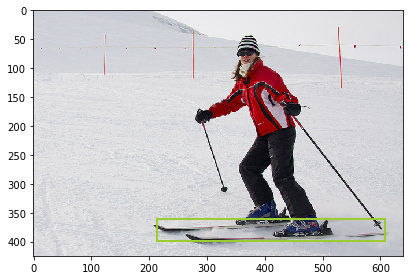

In [150]:
from skimage import io
import numpy as np
k=94
coco=COCO('../../../datasets/coco/annotations/instances_val2017.json')

id=cc_res[k]['image_id']
bounding_box=np.array([cc_res[k]['bbox']])
imgIds = coco.getImgIds(imgIds = [id])
img = coco.loadImgs(imgIds)[0]
I = io.imread(img['coco_url'])
# io.imshow(I)
io.imshow(draw_rect(I,bounding_box))


In [119]:
bounding_box=np.array([cc_res[k]['bbox']])
print(bounding_box.shape)
for cord in bounding_box:
    print(cord)

(1, 4)
[303.29138184 216.41239929  51.03204346  78.86180115]


In [125]:
import cv2
def draw_rect(im, cords, color = None):
  
    im = im.copy()
    if not color:
        color = (154,205,50)
    for cord in cords:
        pt1, pt2 = (cord[0], cord[1]) , (cord[2]+cord[0], cord[3]+cord[1])
        
        pt1 = int(pt1[0]), int(pt1[1])
        pt2 = int(pt2[0]), int(pt2[1])
        
        im = cv2.rectangle(im.copy(), pt1, pt2, color, 2)
    return im

In [112]:
io.imshow(draw_rect(I,bounding_box))

IndexError: index 1 is out of bounds for axis 0 with size 1

In [49]:
k=1
box_attr=pred_final[k]
xmin=box_attr[:,0]/inp_dim * targets[k]['img_size'][1]
ymin=box_attr[:,1]/inp_dim * targets[k]['img_size'][0]
xmax=box_attr[:,2]/inp_dim * targets[k]['img_size'][1]
ymax=box_attr[:,3]/inp_dim * targets[k]['img_size'][0]

0.5
tensor([[  3.6366, 163.6588,  98.9673, 255.9499],
        [284.8031, 163.2458, 304.5559, 295.5597],
        [372.5377, 212.1779, 417.8232, 278.3851],
        [189.1306, 215.9701, 223.4120, 306.4608],
        [194.3501, 215.5452, 229.3885, 308.0600],
        [233.6056, 216.0504, 265.5062, 308.5837],
        [248.9394, 217.1792, 282.5620, 302.7053],
        [358.7329, 294.3815, 380.4102, 392.2944],
        [367.1979, 210.0602, 417.2445, 278.4356],
        [268.2036, 153.3281, 301.6162, 285.2375],
        [269.0005, 160.4503, 301.6859, 297.2227],
        [363.7664, 206.3309, 417.5878, 287.4888],
        [187.1316, 214.6399, 226.5885, 311.0070],
        [189.0628, 212.4594, 233.7171, 311.7639],
        [228.0416, 212.2645, 273.8707, 309.9084],
        [239.0730, 213.7096, 284.3803, 309.2065],
        [290.3692, 117.0838, 300.4048, 137.5092],
        [247.0331, 168.7083, 262.6033, 208.5239],
        [108.5874, 228.7670, 121.3902, 260.9979]], device='cuda:0')


(416, 416, 3)


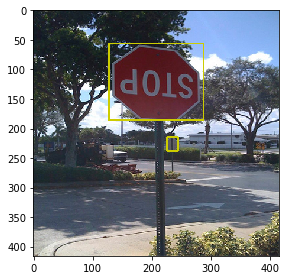

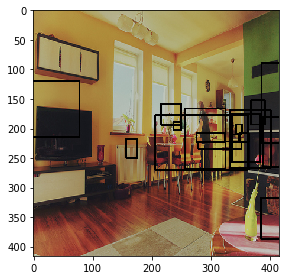

In [28]:
io.imshow(im)

In [1]:
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
cocoGt=COCO('../../../datasets/coco/annotations/instances_val2017.json')

resFile='./cc_bbox_results.json'
cocoDt=cocoGt.loadRes(resFile)
imgIds=sorted(cocoGt.getImgIds())
cocoDt.loadAnns()


# running evaluation
cocoEval = COCOeval(cocoGt,cocoDt,'bbox')
cocoEval.evaluate()
cocoEval.accumulate()
cocoEval.summarize()

loading annotations into memory...
Done (t=0.63s)
creating index...
index created!
Loading and preparing results...
DONE (t=1.85s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=32.30s).
Accumulating evaluation results...
DONE (t=2.54s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.019
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.027
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.022
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.005
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.016
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.040
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.022
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.022
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDet

In [58]:
ome,axis=1)
print(predictions.shape)

torch.Size([8, 255, 13, 13])
torch.Size([8, 10647, 85])


In [1]:
import pandas as pd
import matplotlib.pyplot as plt


bede=pd.read_csv('./benchmark_res_vis_bede.csv')
barkla=pd.read_csv('./benchmark_res_vis_barkla.csv')

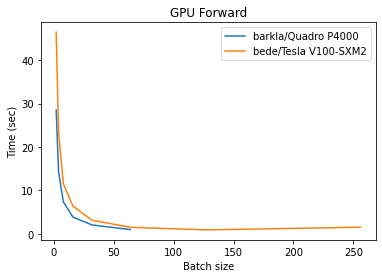

In [19]:
x_axis=bede['batch']
gpu_barkla=barkla['forw_time']
gpu_bede=bede['forw_time']
plt.plot(barkla['batch'], gpu_barkla, label = "barkla/Quadro P4000")
plt.plot(bede['batch'], gpu_bede,label = "bede/Tesla V100-SXM2")
plt.title('GPU Forward')
plt.xlabel('Batch size')
plt.ylabel('Time (sec)')
plt.legend()
plt.savefig('gpu_vis.png')
plt.show()


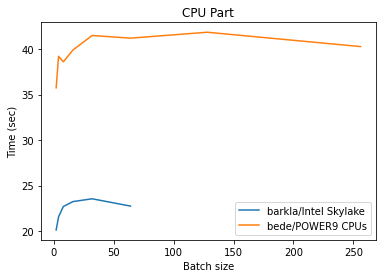

In [20]:
x_axis=bede['batch']
plt.plot(barkla['batch'], barkla['cpu_time'], label = "barkla/Intel Skylake")
plt.plot(bede['batch'], bede['cpu_time'],label = "bede/POWER9 CPUs")
plt.title('CPU Part')
plt.xlabel('Batch size')
plt.ylabel('Time (sec)')
plt.legend()
plt.savefig('cpu_vis.png')
plt.show()

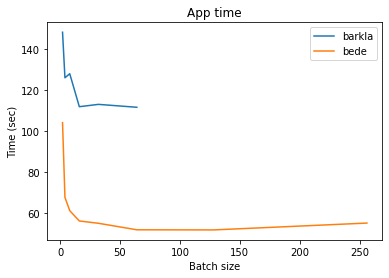

In [21]:
x_axis=bede['batch']
plt.plot(barkla['batch'], barkla['app_time'], label = "barkla")
plt.plot(bede['batch'], bede['app_time'],label = "bede")
plt.title('App time')
plt.xlabel('Batch size')
plt.ylabel('Time (sec)')
plt.legend()
plt.savefig('app_vis.png')
plt.show()

In [24]:
bede=pd.read_csv('./benchmark_res_node_bede.csv')
barkla=pd.read_csv('./benchmark_res_node_barkla.csv')

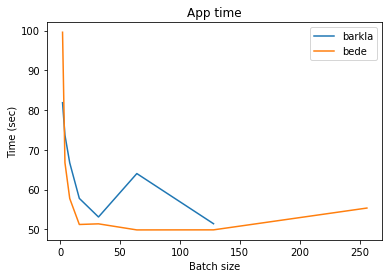

In [25]:
x_axis=bede['batch']
plt.plot(barkla['batch'], barkla['app_time'], label = "barkla")
plt.plot(bede['batch'], bede['app_time'],label = "bede")
plt.title('App time')
plt.xlabel('Batch size')
plt.ylabel('Time (sec)')
plt.legend()
plt.savefig('app_node.png')
plt.show()

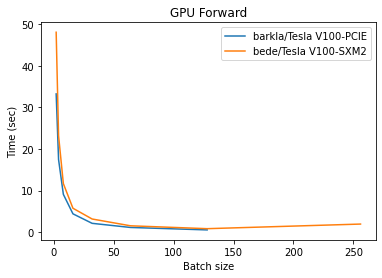

In [26]:
x_axis=bede['batch']
gpu_barkla=barkla['forw_time']
gpu_bede=bede['forw_time']
plt.plot(barkla['batch'], gpu_barkla, label = "barkla/Tesla V100-PCIE")
plt.plot(bede['batch'], gpu_bede,label = "bede/Tesla V100-SXM2")
plt.title('GPU Forward')
plt.xlabel('Batch size')
plt.ylabel('Time (sec)')
plt.legend()
plt.savefig('gpu_node.png')
plt.show()


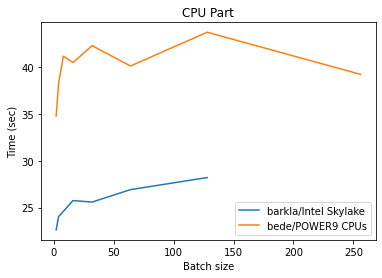

In [27]:
x_axis=bede['batch']
plt.plot(barkla['batch'], barkla['cpu_time'], label = "barkla/Intel Skylake")
plt.plot(bede['batch'], bede['cpu_time'],label = "bede/POWER9 CPUs")
plt.title('CPU Part')
plt.xlabel('Batch size')
plt.ylabel('Time (sec)')
plt.legend()
plt.savefig('cpu_node.png')
plt.show()

In [ ]:
np.array(barkla['map'])-np.array(bede['map'])